In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import technical_indicators as ta #https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py

from sklearn.model_selection import train_test_split
plt.rcParams['figure.figsize'] = (7,4.5) # Make the default figures a bit bigger

In [32]:
#Let's make this notebook reproducible 
np.random.seed(42)
random.seed(42)



In [33]:
import yfinance as yf
import pandas as pd

# 1. Define the ticker and date range
ticker = "NVDA"
start_date = "2022-01-01"
end_date = "2025-12-18" # Fetches up to the current date

# 2. Download the data
# auto_adjust=True handles stock splits (like NVIDIA's 10-for-1 in 2024)
df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
#print(df.columns.get_level_values(1))
df.columns=[col[0] for col in df.columns.values]
df.rename(columns={'index': 'Date'}, inplace=True)
df= df.reset_index()
print("New Columns:", df.columns.tolist())

# 3. Quick look at the data
print(df.head())
print(f"\nTotal rows downloaded: {len(df)}")



[*********************100%***********************]  1 of 1 completed

New Columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
        Date      Close       High        Low       Open     Volume
0 2022-01-03  30.062765  30.651625  29.727414  29.757357  391547000
1 2022-01-04  29.233372  30.409094  28.294191  30.218463  527154000
2 2022-01-05  27.550634  29.359132  27.479772  28.893033  498064000
3 2022-01-06  28.123520  28.383017  27.012673  27.586560  454186000
4 2022-01-07  27.194321  28.367050  27.004687  28.086593  409939000

Total rows downloaded: 994


In [34]:
def get_exp_preprocessing(df, alpha=0.9):
    edata = df.select_dtypes(include=['number']).ewm(alpha=alpha).mean()  
    if 'Date' in df.columns:
        edata['Date']=df['Date']
    return edata

In [35]:
snvda = get_exp_preprocessing(df)
#snvda.head()

In [36]:
print(df.columns)

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [37]:
def feature_extraction(df):
   
    for x in [5, 14, 26, 44, 66]:
        df = ta.relative_strength_index(df, n=x)
        df = ta.stochastic_oscillator_d(df, n=x)
        df = ta.accumulation_distribution(df, n=x)
        df = ta.average_true_range(df, n=x)
        df = ta.momentum(df, n=x)
        df = ta.money_flow_index(df, n=x)
        df = ta.rate_of_change(df, n=x)
        df = ta.on_balance_volume(df, n=x)
        df = ta.commodity_channel_index(df, n=x)
        df = ta.ease_of_movement(df, n=x)
        df = ta.trix(df, n=x)
        df = ta.vortex_indicator(df, n=x)
    
    df['ema50'] = df['Close'] /df['Close'].ewm(50).mean()
    df['ema21'] = df['Close'] / df['Close'].ewm(21).mean()
    df['ema14'] = df['Close'] / df['Close'].ewm(14).mean()
    df['ema5'] = df['Close'] / df['Close'].ewm(5).mean()
        
    #Williams %R is missing
    df = ta.macd(df, n_fast=12, n_slow=26)
    
    del(df['Open'])
    del(df['High'])
    del(df['Low'])
    del(df['Volume'])
    
    return df


In [38]:
#Define X and y for feature engineering and model training

# 1. Ensure it's sorted (just in case)
df = df.sort_values('Date').reset_index(drop=True)

In [39]:
def compute_prediction_int(df, n):
    pred = (df.shift(-n)['Close'] >= df['Close'])
    pred = pred.iloc[:-n]
    return pred.astype(int)

def prepare_data(df, horizon):
    df = feature_extraction(df).dropna().iloc[:-horizon]
    df['pred'] = compute_prediction_int(df, n=horizon)
    del(df['Close'])
    return df.dropna()

In [40]:
#Define X and y for model training and Feature Engineering

df = prepare_data(snvda, 10)

y = df['pred']

#remove the output from the input
features = [x for x in df.columns if x not in ['gain', 'pred']]
X = df[features]
print(y)


196    1.0
197    1.0
198    1.0
199    1.0
200    1.0
      ... 
969    0.0
970    0.0
971    0.0
972    0.0
973    0.0
Name: pred, Length: 778, dtype: float64


In [41]:
data = prepare_data(snvda, 10)

y = data['pred']

#remove the output from the input
features = [x for x in data.columns if x not in ['gain', 'pred']]
X = data[features]


In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SequentialFeatureSelector

In [43]:

# 1. Setup the split
tscv = TimeSeriesSplit(n_splits=2)

# We use the loop to define our final X_train/X_test
for train_index, test_index in tscv.split(X):
    X_train_raw, X_test_raw = X.iloc[train_index], X.iloc[test_index]
    y_train_raw, y_test_raw = y.iloc[train_index], y.iloc[test_index]

# 2. Drop Date if it exists
X_train = X_train_raw.drop(columns=['Date'], errors='ignore')
X_test= X_test_raw.drop(columns=['Date'], errors='ignore')






In [44]:
#Removing zero variance col



# 1. Remove Constant Features (Threshold = 0)
# This keeps only columns that actually change
selector = VarianceThreshold(threshold=0)
X_train_v = selector.fit_transform(X_train)

# Get the names of the columns that were kept
selected_cols = X_train.columns[selector.get_support()]
X_train_filtered = pd.DataFrame(X_train_v, columns=selected_cols)
X_test_filtered = X_test[selected_cols]

print(f"Removed {len(X_train.columns) - len(selected_cols)} constant columns.")

Removed 0 constant columns.


In [45]:
# 2. Identify and Remove Highly Correlated Features
def remove_collinear_features(df, threshold=0.90):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    return to_drop

cols_to_drop = remove_collinear_features(X_train_filtered)
X_train_final = X_train_filtered.drop(columns=cols_to_drop)
X_test_final = X_test_filtered.drop(columns=cols_to_drop)

print(f"Dropped {len(cols_to_drop)} redundant features: {cols_to_drop}")

Dropped 22 redundant features: ['ATR_14', 'ROC_14', 'CCI_14', 'RSI_26', 'SO%d_26', 'ATR_26', 'CCI_26', 'RSI_44', 'SO%d_44', 'ATR_44', 'CCI_44', 'Vortex_44', 'RSI_66', 'SO%d_66', 'ATR_66', 'CCI_66', 'Vortex_66', 'ema50', 'ema21', 'ema14', 'MACD_12_26', 'MACDsign_12_26']


. Sequential Feature Selection (SFS)

Instead of looking at all features at once, SFS adds features one by one and checks if the accuracy actually improves. This is better than "Importance" because it directly optimizes for your 10-day target.

In [46]:
# Setup Sequential Feature Selector

sfs_rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)


#We specify  n_features_to_select=7 to make model simpler , since its only 10 day window
sfs = SequentialFeatureSelector(
    sfs_rf, 
    n_features_to_select=7, 
    direction='forward', 
    cv=tscv, 
    n_jobs=-1
)

# 3. Fit SFS on the data AFTER collinearity removal
print("Starting Sequential Feature Selection (this may take a minute)...")
sfs.fit(X_train_final, y_train_raw.values.ravel())

# 4. Get the names of the "Dream Team" features
sfs_features = X_train_final.columns[sfs.get_support()].tolist()

print("\nSFS 'Dream Team' Features for 10-Day Prediction:")
print(sfs_features)

Starting Sequential Feature Selection (this may take a minute)...

SFS 'Dream Team' Features for 10-Day Prediction:
['EoM_5', 'SO%d_14', 'MFI_14', 'EoM_14', 'EoM_26', 'EoM_44', 'EoM_66']


In [ ]:
# 5. Train the FINAL model (Default settings for random forest)
# 5. Filter data to ONLY SFS features

X_train_sfs = X_train_final[sfs_features]
X_test_sfs = X_test_final[sfs_features]
final_rf_sfs = RandomForestClassifier(random_state=42, n_jobs=-1)
final_rf_sfs.fit(X_train_sfs, y_train_raw.values.ravel())

# 6. Check the score
sfs_accuracy = final_rf_sfs.score(X_test_sfs, y_test_raw)
print(f"Baseline Accuracy with SFS features: {sfs_accuracy:.4f}")

# Hyper tuning  using # Hyper tuning  using 

In [51]:
from sklearn.model_selection import RandomizedSearchCV


# 1. Define the parameter grid
# We target depth and leaf size specifically to fit previous accuracy drop
param_dist = {
    'n_estimators': [100, 300, 500, 800],
    'max_depth': [5, 8, 12, 20, None],
    'min_samples_leaf': [5, 10, 20, 50],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# 2. Initialize the model
rf_tune = RandomForestClassifier(random_state=42, n_jobs=-1)

# 3. Setup Randomized Search
# We use  tscv (TimeSeriesSplit) to ensure the tuning is valid for time-series
random_search = RandomizedSearchCV(
    estimator=rf_tune,
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    cv=tscv,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 4. Fit on the SFS selected features ONLY
print("Starting Hyperparameter Tuning...")
random_search.fit(X_train_sfs, y_train_raw.values.ravel())

# 5. Extract the best model
best_rf = random_search.best_estimator_

# 6. Evaluate
final_accuracy = best_rf.score(X_test_sfs, y_test_raw)

print(f"\nBest Params Found: {random_search.best_params_}")
print(f"Final Tuned Accuracy: {final_accuracy:.4f}")

Starting Hyperparameter Tuning...
Fitting 2 folds for each of 20 candidates, totalling 40 fits

Best Params Found: {'n_estimators': 500, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': None, 'class_weight': None}
Final Tuned Accuracy: 0.5907


              precision    recall  f1-score   support

         0.0       0.62      0.18      0.27       114
         1.0       0.59      0.92      0.72       145

    accuracy                           0.59       259
   macro avg       0.61      0.55      0.49       259
weighted avg       0.60      0.59      0.52       259



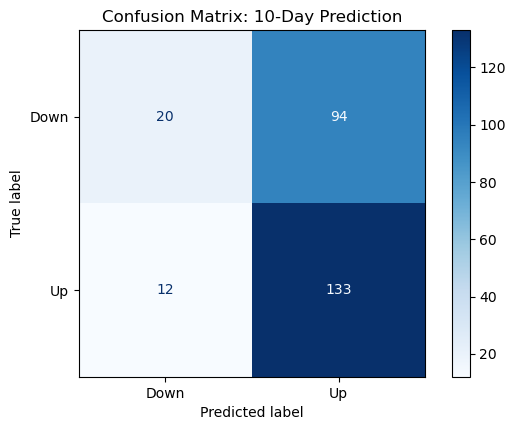

In [55]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 1. Get predictions
y_pred = best_rf.predict(X_test_sfs)

# 2. Print the detailed report
# Look at "Precision" for class 1 (Up) — this is your 'Win Rate'
print(classification_report(y_test_raw, y_pred))

# 3. Plot the Confusion Matrix
cm = confusion_matrix(y_test_raw, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: 10-Day Prediction')
plt.show()

This model currently functions as a "Perma-Bull," a common trait in financial machine learning where the algorithm prioritizes catching every possible gain (92% Up-Recall) at the expense of ignoring risk (18% Down-Recall). While a 59% Precision makes this profitable during steady uptrends, the model’s inability to "see" downturns means it offers no protection during market corrections or bear cycles. It essentially treats the market as a one-way street, betting on growth by default because that has been the historically successful path for stocks like NVDA. To transform this from a simple trend-follower into a sophisticated trading tool, you must raise the probability threshold (e.g., to 0.55 or 0.60). This forces the model to be "pickier," sacrificing some total trades to ensure that when it does signal a "Buy," it has a significantly higher mathematical certainty, effectively filtering out the "coin-flip" scenarios that lead to heavy losses.

 

In [48]:
#Probability based signal selection
# Calculate current probaibility for  up signal
y_probs = best_rf.predict_proba(X_test_sfs)[:, 1] 
y_pred_strict = (y_probs > 0.55).astype(int)     # Only predict 'Up' if 55% sure

# Now check the classification report for y_pred_strict

# 1. Get the standard predictions (50% threshold)
y_pred = best_rf.predict(X_test_sfs)

# 2. Print the standard report
print("--- Standard Classification Report (50% Threshold) ---")
print(classification_report(y_test_raw, y_pred))

# 3. Optional: Check with a "Strict" Threshold (e.g., 55% confidence)
# This often helps reduce 'False Buys' in stock models
y_probs = best_rf.predict_proba(X_test_sfs)[:, 1]
y_pred_strict = (y_probs > 0.55).astype(int)

print("\n--- Strict Classification Report (55% Threshold) ---")
print(classification_report(y_test_raw, y_pred_strict))

--- Standard Classification Report (50% Threshold) ---
              precision    recall  f1-score   support

         0.0       0.62      0.18      0.27       114
         1.0       0.59      0.92      0.72       145

    accuracy                           0.59       259
   macro avg       0.61      0.55      0.49       259
weighted avg       0.60      0.59      0.52       259


--- Strict Classification Report (55% Threshold) ---
              precision    recall  f1-score   support

         0.0       0.56      0.22      0.31       114
         1.0       0.58      0.86      0.70       145

    accuracy                           0.58       259
   macro avg       0.57      0.54      0.51       259
weighted avg       0.57      0.58      0.53       259



<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

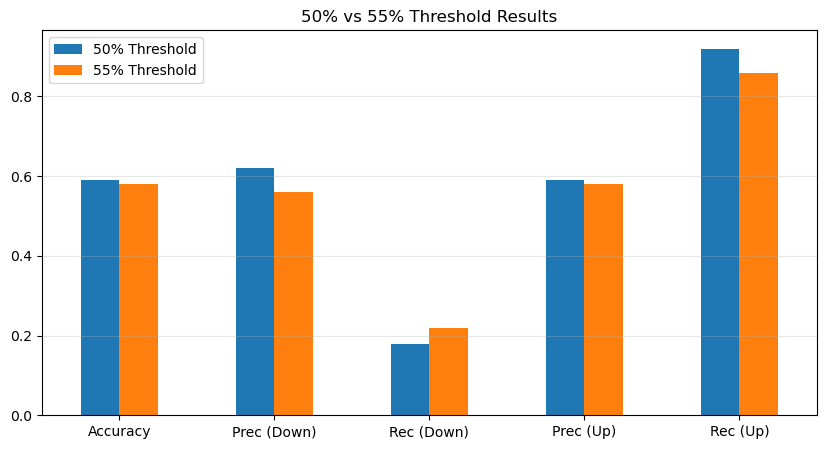

In [56]:

plt.figure(figsize=(10, 5))
# Data from reports
df = pd.DataFrame({
    '50% Threshold': [0.59, 0.62, 0.18, 0.59, 0.92],
    '55% Threshold': [0.58, 0.56, 0.22, 0.58, 0.86]
}, index=['Accuracy', 'Prec (Down)', 'Rec (Down)', 'Prec (Up)', 'Rec (Up)'])

# Plotting
plt.figure(figsize=(10, 5))
df.plot(kind='bar', rot=0, figsize=(10, 5), title="50% vs 55% Threshold Results")
plt.grid(axis='y', alpha=0.3)
plt.show() 